# COSC 426 / 526 - Assignment 05
### Discussed: February 21, 2025
### Due: Feb 28, 2025
---

In this notebook, we provide you with basic functions for completing the assignment. *Complete the assignment in this notebook. You must modify existing code and write new code to find a solution.*

*Note:* Running a cell will not rerun previous cells. If you edit code in previous cells, you must rerun those cells. If you are having trouble with undefined errors and code changes not applying, we recommend using `Run All` to avoid any errors resulting from not rerunning previous cells. You can find this in the menu above: `Cell -> Run All`

During Lectures 3 and 4, we learned about the **MapReduce** programming model. In this assignment, we will use the **MapReduce** programming model to solve the text parsing problems that we addressed in Assignment 4 *using the power of the MapReduce programming model*. Python provides `map` and `reduce` functions for lists that do not use parallel processing (i.e., sequential). However, they work in a similar way to the parallel implementations found in *Apache Spark*. We define three methods (i.e., `mapSequential`, `reduceSequential`, and `reduceByKeySequential`) that extend Python's `map` and `reduce` functions to act like those in *Apache Spark*. We will use *sequential* **MapReduce** to develop methods that can be used with the *parallel* **MapReduce** from *Apache Spark*.

The following table lists examples of inputs and outputs to different **MapReduce** methods.  See if you can determine how the output was computed with the input:

| Input                          | Function   | MapReduce Call | Output               |
|--------------------------------|------------|----------------|----------------------|
| [1,2,3]                        | f(x)=x+1   | Map            | [2,3,4]              |
| [1,2,3]                        | f(x,y)=x+y | Reduce         | 6                    |
| [('a', 1), ('b', 2), ('a', 3)] | f(x,y)=x+y | ReduceByKey    | [('a', 4), ('b', 2)] |

Now let's check that these functions work without sequential implementation of `map`, `reduce`, and `reduceByKey`:

In [1]:
import itertools
import functools

# We wrap the original python map and reduce functions to be more powerful and resilient
def mapSequential(data, func):
    return list(map(func, data))

def reduceSequential(data, func):
    return functools.reduce(func, data)

def reduceByKeySequential(data, func):
    reduced_data = []
    for key, vals in itertools.groupby(sorted(data, key=lambda x: x[0]), key=lambda x: x[0]):
        reduced_data.append((key, reduceSequential([x[1] for x in vals], func)))
    return reduced_data

In [2]:
# Define our three inputs
input_1 = [1,2,3]
input_2 = [1,2,3]
input_3 = [('a', 1), ('b', 2), ('a', 3)]

# Define the two functions used
def plusOne(x):
    return x + 1

def add(x, y):
    return x + y

# Apply our functions to our inputs
output_1 = mapSequential(input_1, plusOne)
output_2 = reduceSequential(input_2, add)
output_3 = reduceByKeySequential(input_3, add)

# Print out outputs
print('Output 1:', output_1)
print('Output 2:', output_2)
print('Output 3:', output_3)

Output 1: [2, 3, 4]
Output 2: 6
Output 3: [('a', 4), ('b', 2)]


### Data Pre-Processing:
Below is code to open a text file and return a list of words containing only upper-case unicode characters.  We use this to read the text file (i.e., "The Count of Monte Cristo") and prepare the text for the following three problems.  The output, which you should use for solving the assignment problems, is named `words`.

In [3]:
# Import regular expressions library
import re


# Define a method for reading and processing text files
def loadText(f_name):
    # Read the text file
    with open(f_name, 'r') as f:
        text_lines = f.readlines()

    # Concatenate the list of strings into a single string
    text_all = ''.join(text_lines)

    # Remove all non-alphabet characters with a regular expression
    text_alpha = re.sub(r'[^a-zA-Z]', ' ', text_all)

    # Convert characters to upper-case
    text_upper = text_alpha.upper()
    
    # Convert the string of text into a list of words and remove empty words
    words = [w for w in text_upper.split(' ') if w != '']
    
    return words


# Load list of words
words = loadText('book_CountOfMonteCristo.txt')

### Problem 1:
Analyze the text for word length frequency. We might expect short words to be more common than long words. But, are words of length 2 more common than words or length 3? Are words of length 3 more common that words of length 4? **Use the pre-processed text, `words`, from the previous cell to count the frequency of each word length in the text using the sequential MapReduce methods we defined above**.  

*Complete the definition of functions in the following cell.  These functions are used in the next cell with the `map` and `reduce` calls that we have defined for you above.*

In [4]:
# Return the length of a given word
def wordLength(word):
    return len(word)


# Given a key and value, return a (key, value) pair
def makeKeyValue(key, value=1):
    return (key, value)


# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2


In [5]:
# Map the length of each word
word_lengths = mapSequential(words, wordLength)
    
# Map keyvalue pairs to help count each word length
word_keyvalues = mapSequential(word_lengths, makeKeyValue)
    
# ReduceByKey to count number of words with each length
word_length_counts = reduceByKeySequential(word_keyvalues, addValues)

# Sort word length by most common
wl_counts_sorted = sorted(word_length_counts, key=lambda x: x[1], reverse=True)

# Print the 6 most common word lengths
print('Word Length : Count')
for word_len, count in wl_counts_sorted[:6]:
    print('{:<11d} : {:>6d}'.format(word_len, count))

Word Length : Count
3           : 109798
2           :  84021
4           :  81777
5           :  49101
6           :  39015
7           :  30701


#### Expected Output:
```
Word Length : Count
3           : 109798
2           :  84021
4           :  81777
5           :  49101
6           :  39015
7           :  30701
```

### Problem 2:
For this problem, it may be beneficial to use another **MapReduce** function from *Apache Spark*: `flatMap`.  We define `flatMapSequential` below.  `flatMap` has the ability to expand the number of elements in a mapped iterable by flattening a list of lists into a single list. 

In [6]:
def flatMapSequential(data, func):
    mapped_data = mapSequential(data, func)
    flattened_data = [item for lst in mapped_data for item in lst]
    return flattened_data

To help you become familiar with `flatMap`, we have an example below which should make the difference between `map` and `flatMap` apparent.

In [7]:
# Define a list of lists of integers for testing
test = [[1,2,3], [4,5,6], [7,8,9]]

# Define a function that returns the input
def dummyFunc(x):
    return x

# Let's apply a map with our dummy function
test_map = mapSequential(test, dummyFunc)
print('map:', test_map)

# Let's apply a flatMap with our dummy function
test_flatmap= flatMapSequential(test, dummyFunc)
print('flatmap:', test_flatmap)

map: [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
flatmap: [1, 2, 3, 4, 5, 6, 7, 8, 9]


Do you see the different between `map` and `flatMap`?  If not, modify the code and try it with a different input or different function.  In general, the function with which you call `flatMap` should return an iterable (e.g., list or tuple).

Getting back to the problem...  Analyze the text for letter frequency. If you’ve taken a crypto course and/or have seen substitution ciphers then you are probably aware that ’e’ is the most common letter used in the English language.  **Use the pre-processed text `words` to count the frequency of each letter in the text using the sequential MapReduce methods we defined above**. 

*Complete the `splitWord` function in the following cell, then fill in the code in the cell after. Much of this code will be similar to the final cell of Problem 1, including `map` and `reduce` calls using functions defined in Problem 1.  Did you write those functions general enough to be reused?*

In [8]:
# Given a word, return an iterable of characters
def splitWord(word):
    return list(word)

In [9]:
# The next two calls require you to use a map function.  
# Think about which map (i.e., flatMap or Map) is most suitable.

# Map list of words to list characters.
chars = flatMapSequential(words, splitWord) # <Define your map function here that calls splitWord()>

# Map list of characters to list of key-value pairs.
char_keyvalues = mapSequential(chars, makeKeyValue) #<Define your next map function here>

# ReduceByKey to count number of occurrences of each letter.
char_counts = reduceByKeySequential(char_keyvalues, addValues) #<Define your reduce function here>

# Sort letters by most common.
char_counts_sorted = sorted(char_counts, key=lambda x: x[1], reverse=True) #<Sort char_counts here>

# Print the 6 most common characters.
print("{:<12} : {:<8}".format("Character", "Count"))
for char, count in char_counts_sorted[:6]:
    print("{:<12} : {:<8}".format(char, count))

Character    : Count   
E            : 258693  
T            : 180211  
A            : 165306  
O            : 156817  
I            : 142095  
N            : 137343  


#### Expected Output:
```
Character : Count
E         : 258693
T         : 180211
A         : 165306
O         : 156817
I         : 142095
N         : 137343
```

### Problem 3:
For this problem, it may be beneficial to use the `numpy` package.  Specifically, the element-wise addition of numpy array may come in handy.  Below is an example of what happens when you add two numpy arrays.

In [10]:
# Let's see a useful property of numpy arrays
# HINT: ref [1]
import numpy as np

# Define numpy arrays
a = np.array([1,1,0])
b = np.array([0,1,0])

# Print each array and the sum of each array
print('  a:', a)
print('  b:', b)
print('a+b:', a+b)

  a: [1 1 0]
  b: [0 1 0]
a+b: [1 2 0]


**References:**
- [1: numpy quickstart](https://docs.scipy.org/doc/numpy/user/quickstart.html)

If we really wanted to crack a substitution cipher (or win on ”Wheel of Fortune”) then we should be aware that, although ’e’ is the most common letter used in English, it may not be the most common first letter in a word. **Count the positional frequencies of each letter using the sequential MapReduce methods we defined above. Specifically, count the number of times each letter appears as the first letter in a word, as the last letter in a word, and as an interior letter in a word (i.e. a letter that is neither first nor last)**.  

*Complete the `lettersPosition` function below, then fill in the code in the cell after.  Your functions are used with `map` and `reduce` calls that we have defined.  Note that we use a function that has also been used in Problems 1 and 2. Using numpy arrays in the following function definition could make this assignment easier.  However, you are not required to use numpy.  Feel free to change code by adding more maps or reduces in order to get a correct answer.*

In [11]:
# Define a method to return position of each character
# You may want to reference your solution from assignment 3
# Remember how the reduceByKey will use the returned values when writing a solution
def lettersPosition(word):
    #Each char format: ('A', [1, 0, 0])
    positions = [
        (char, np.array([int(i == 0), int(0 < i < len(word)-1), int(i == len(word)-1 and i != 0)]))
        for i, char in enumerate(word)
    ]
    return positions

In [12]:
# Map the location of each character
char_positions = flatMapSequential(words, lettersPosition) #<Define your map function here that calls letterPosition()>

# ReduceByKey the letter positions for each character
char_position_counts = reduceByKeySequential(char_positions, addValues) #<Define your reduce function here>

# Sort character position data alphabetically
cp_sorted = sorted(char_position_counts, key=lambda x: x[0]) #<Sort char_position_counts here>

# Print the position frequency of the first letters in the alphabet
print('Character : First | Interior |  Last')
for char, char_position in cp_sorted[:6]:
    first, interior, last = char_position
    print('{:<9} : {:5d} | {:>8d} | {:>5d}'.format(char, first, interior, last))

Character : First | Interior |  Last
A         : 51644 |   111686 |  1976
B         : 18866 |     8516 |   541
C         : 19577 |    32130 |   725
D         : 17289 |    18613 | 58075
E         : 10178 |   153205 | 95310
F         : 17724 |    10618 | 16988


#### Expected Output:
```
Character : First | Interior |  Last
A         : 51644 |   111686 |  1976
B         : 18866 |     8516 |   541
C         : 19577 |    32130 |   725
D         : 17289 |    18613 | 58075
E         : 10178 |   153205 | 95310
F         : 17724 |    10618 | 16988
```

### Problem 4:
Repeat Problem 2 with a new text, one you expect to have different letter distribution than The Count of Monty Cristo. You could use something written centuries earlier (e.g., Shakespeare or an early English translation of the Bible), in a distinctive style or genre (e.g., poetry or a contract), or even in a different language.

In [13]:
# Place the .txt file in the folder with this Jupyter Notebook, then load it to a list of words.
# If your text is in a language with different characters than English, 
#  you will have to create a modified version of the function loadText().

play_words = loadText('plays_of_sophocles.txt')

# Compute char_counts_sorted as in Problem 2.
chars = flatMapSequential(play_words, splitWord) # <Define your map function here that calls splitWord()>
char_keyvalues = mapSequential(chars, makeKeyValue) #<Define your next map function here>
char_counts = reduceByKeySequential(char_keyvalues, addValues) #<Define your reduce function here>
char_counts_sorted = sorted(char_counts, key=lambda x: x[1], reverse=True) #<Sort char_counts here>

# Print the most frequent characters to compare with the results from Problem 2.
print("{:<12} : {:<8}".format("Character", "Count"))
for char, count in char_counts_sorted[:6]:
    print("{:<12} : {:<8}".format(char, count))

Character    : Count   
E            : 21988   
T            : 15665   
O            : 14147   
A            : 12662   
S            : 12164   
N            : 11437   


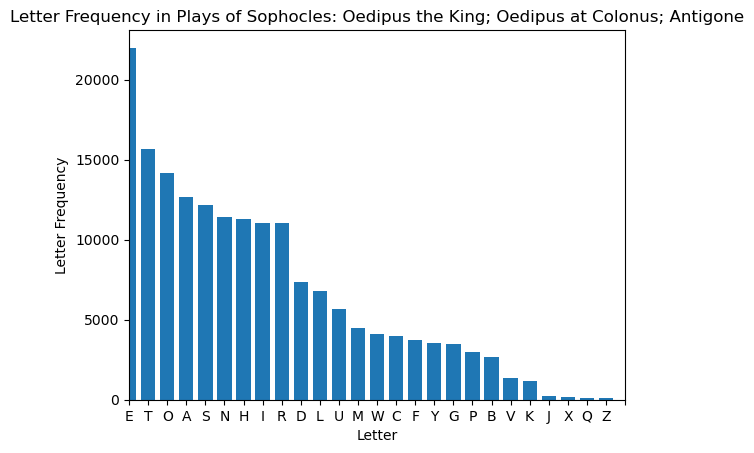

In [14]:
from matplotlib import pyplot as plt

#Plot histogram for frequent characters in Oedipus plays (text 2)
X_vals, Y_vals = zip(*char_counts_sorted)
plt.bar(X_vals, Y_vals, 0.75)
plt.xlim((.125, len(X_vals)))
plt.xticks(range(0,len(X_vals)+1,1))
plt.xlabel('Letter')
plt.ylabel('Letter Frequency')
plt.title('Letter Frequency in Plays of Sophocles: Oedipus the King; Oedipus at Colonus; Antigone')
plt.show()

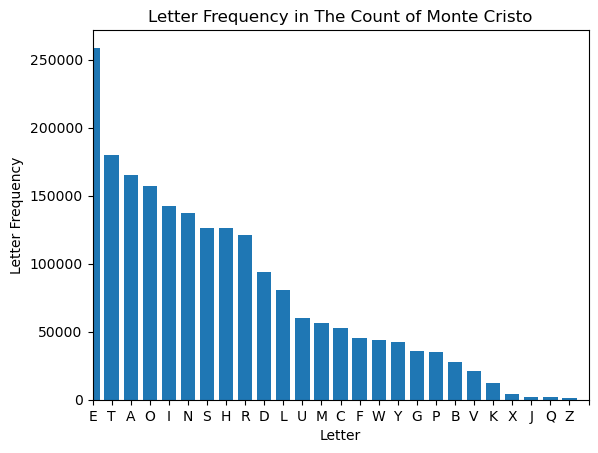

In [15]:
#Plot histogram for frequent characters in The Count of Monte Cristo
chars = flatMapSequential(words, splitWord) # <Define your map function here that calls splitWord()>
char_keyvalues = mapSequential(chars, makeKeyValue) #<Define your next map function here>
char_counts = reduceByKeySequential(char_keyvalues, addValues) #<Define your reduce function here>
char_counts_sorted = sorted(char_counts, key=lambda x: x[1], reverse=True) #<Sort char_counts here>

# Plot the histogram for problem 2
X_vals, Y_vals = zip(*char_counts_sorted)
plt.bar(X_vals, Y_vals, 0.75)
plt.xlim((.125, len(X_vals)))
plt.xticks(range(0,len(X_vals)+1,1))
plt.xlabel('Letter')
plt.ylabel('Letter Frequency')
plt.title('Letter Frequency in The Count of Monte Cristo')
plt.show()

### Things to Consider:
In this assignment you wrote functions that can be used with the **MapReduce** programming model.  The `map` and `reduce` functions were sequential, but they work in the same way as the parallel versions.  This means that the functions you wrote in this assignment can be used in the next assignment where we use **MapReduce** in parallel with *Apache Spark*!

## Problem 5. Write the comprehensive README files for the assignment

**Note:** These directions are for a README file for your assignments. An more extensive README file should be used for your project. 

***Write the comprehensive README files for this assignment***

A comprehensive README file on GitHub is the primary information source for anyone exploring your repository. It is essential for clearly conveying your assignment's purpose, setup, and usage.

Key elements of a comprehensive README for an assignment include:

Assignment title: This should clearly state the name of your project.

Assignment description: Provide a concise overview of what the project entails. This section should explain the project's usefulness and the problems it addresses.

Installation instructions: Offer detailed steps for setting up the project. This includes any prerequisites, dependencies, and a step-by-step guide to operationalizing the project.

Use: Give clear instructions on how to use the project. Enhance this section with practical examples, including code snippets, screenshots, or videos.

Contact information: Detail how to contact you. This could be through email.

Acknowledgments: Credit any individuals, organizations, or other entities contributing significantly to the assignment.

**Add the README file to the GitHub repository with the solution of this assigment.**

### Live Chat:2020 Breakthrough Prize Winner Shep Doeleman—How EHT Imaged a Black Hole

Watch the insightful video featuring Shep Doeleman, the 2020 Breakthrough Prize Winner, as he discusses how the Event Horizon Telescope (EHT) captured the first-ever image of a black hole. You can find the video at this link: https://www.youtube.com/watch?v=KHa0X4y3ulw

After watching the video, answer the following questions:

* What is the connection between the EHT project and data sciences?
* What obstacles did the scientists encounter while reconstructing the first image of a black hole? Were they restricted to using a single telescope or gathering data from multiple locations? Why? How did they transfer the data from the telescopes to their institutions? Why? 
* How did the team overcome these challenges?

Share your insights and reflections after watching the video!

- **What is the connection between the EHT project and data sciences?**

Data collection and visualization algorithms were utilized to compile the black hole image.


- **What obstacles did the scientists encounter while reconstructing the first image of a black hole? Were they restricted to using a single telescope or gathering data from multiple locations? Why? How did they transfer the data from the telescopes to their institutions? Why?**

A big obstacle was the scientists needed a telescope as big as the size of the Earth to peer into galaxies and bring a black hole into focus. The solution was to use existing dishes around the globe and link them into a network so they can cover the equivalent of an Earth-sized telescope. Since the data was in petabytes, they found the fastest way to transfer the data to a central facility was store them on hard disks and fly them on a Boeing 747 plane to the facility. The speaker mentioned that it would take 25 years to get data from the South Pole station to the facility, so physically flying them is much faster. With the separate hard disks from other stations, they can play them back, align them in time, and combine into one dataset. When they compile the final black hole image, they learned that adding more stations made the ring clearer. 

- **How did the team overcome these challenges?**

Another challenge was combating human bias. The team split into 4 smaller teams (Americas, Global, East Asia, and Cross Atlantic) and spent 6-7 weeks of isolation from each other using different approaches to compile the black hole image. After the period, they came together for an imaging comparison workshop and found that they all had the same ring structure even with 3 different algorithms. To fine-tune the algorithms, they created fake datasets and added known errors from the telescope system to ensure they are seeing a real shadow.

### Project: 

Select a Project Example: Choose one project example from the Lecture 5 folder. Read the extended abstract associated with the selected project.

Analyze the Posters: Examine the posters and mark the following pieces of information:
* Type of data
* Question(s) answered
* Method(s) used
* Key outcomes and results

Analyze the Sections: Identify the parts in the abstracts presenting:
* Problem definition
* Methodology to resolve the problem
* Outcome/results

Report Writing: Write a short report (maximum 600 words) answering the following questions:
* What are the common components of both the abstract and poster?
* What are the key differences between the abstract and poster?
* What is the role of pictures in the abstract and poster? Compare and contrast.
* What is the role of text in abstracts and posters? Compare and contrast.

Submission Guidelines:
* Submit your analysis report as a written text in this Notebook.
* Ensure that your report is clear, concise, and well-organized.
* Include appropriate headings and subheadings to structure your analysis.
* Provide references to the selected project example, abstract, and poster.

# Analyzing Abstract and Poster of "Leveraging Spark and Docker for Scalable, Reproducible Analysis of Railroad Defects"

### Similarities of Abstract & Poster
The commonalities of the abstract and poster are that they cover the problem definition, methodology, results, and conclusion. They both cover the motivation of the problem and general information about the data sets. The workflow section of the poster and the methodology section of the paper have overlapping facts. While not the same, the block diagrams showcasing the workflow are similar. The results, like the classifier achieving an accuracy of 89.90% [1], are the same and are illustrated with identical figures. Lastly, the poster and abstract mention the same conclusions.

### Differences of Abstract & Poster
The key difference is that the poster omits more details but is the finalized, presentation-ready version of the research. While the poster covers the basic motivations of the problem definition, it cuts out the more detailed explanation of why predicting railroad defects is significant to preventing railway accidents [1]. The intro of the extended abstract fleshes out the need for this research. Additionally, the poster specifies actual data point numbers like 26,432 20-dimensional data points in the rail defects data set [2] versus where they originated from or a more detailed explanation of what the data contains. Naturally, the abstract goes more in-depth on how the classifier was trained, mentioning that the data was split into 70% training and 30% testing [1]. The abstract also includes details about future work which did not make it to the final poster. 

While the poster excludes extra information, it includes updated, more informative figures than the abstract. The poster's workflow diagram is not only aesthetically better but also more detailed since the abstract has the space to elaborate on the figure. In fact, they must have only had the DockerHub link ready to share once they created the poster because there is no mention of it in the abstract [2]. The poster has more confusion matrices and charts to better illustrate the results. Surprisingly, the Chi-Squared Similarity equation is also slightly different than the one in the abstract.

### Roles of Abstract & Poster
These differences exist because the abstract and poster serve separate roles. The extended abstract needs to talk about all the gritty details of the research. The text can be as lengthy as it wants, within reason and submission guidelines, because it has the space to do so. A typical paper should have enough written so the reader has an idea of how to reproduce the results. Pictures and figures in the abstract should further illustrate points in the paper or visualize results. There are not as many of these in a paper because text is the main focus, and the column structure of the paper makes it harder to include lots of images without going over the page limit. 

In contrast, a poster is the summarization of the paper and should highlight important information in a quick glance. The poster has more images than text because images are more eye-catching and can visually show more results than listing them in text. Plus, the viewers are more focused on listening to you verbalize the research than reading the poster. Text and images serve the same the purpose in both the abstract and poster, but the quantity and quality of them differ depending on deliverance of the research. 

### References
[1]  D. Chapp and S. Kasturi. Leveraging Spark and Docker for scalable, reproducible analysis of railroad defects.

[2]  D. Chapp and S. Kasturi. Poster for Leveraging Spark and Docker for scalable, reproducible analysis of railroad defects.

In [ ]:
#Just to divde the sections

### Reflect on your experience with the lecture and assignment:

Q1: Resource usage: What external resources (websites, books, etc.) did you consult while working on the problems? Please list them.

Q2: Debugging and error resolution: How often did you encounter and resolve errors or bugs during the assignment? Could you describe each occurrence in detail?

Q3: Gained knowledge: What lessons or insights you learned from solving these problems? How do you apply these insights in future coding projects or problem-solving scenarios?

Q4: Collaborative experiences: If you consulted with others, explain how this collaboration influenced your problem-solving approach. If you consulted with others, can you give an example of how you helped a peer or how a peer's advice helped you?

**Important Note:** Your reflections and experiences shared in response to these questions are as crucial as the solutions for the coding problems. Responses that are too brief or limited to a few words will not suffice and may  affect the pass grade for your assignment.

1. The only external resource I used was Project Gutenburg to find a second text to complete Problem 4. I used *Plays of Sophocles: Oedipus the King; Oedipus at Colonus; Antigone* by Sophocles (https://www.gutenberg.org/ebooks/31).

2. The only bug I had was implementing the lettersPosition() function. I thought I could get away with reusing my code from Assignment 4, but it turned out to be very slow when running. The instructions suggest using numpy, so it took a bit of thinking to condense my code to something faster and more efficient.

3. I really did not know you could pass functions as parameters for other functions. Also, I didn't have a lot of experience using Python's map and reduce functions. Completing this assignment makes me feel more comfortable using MapReduce and is good preparation for the next assignment when we use Apache Spark. 

4. I did not consult with others, but I would imagine I would double check with others how all the functions work together. I wasn't sure at first if the little functions like addValue() were that simple. 